In [2]:
# 1. 导入库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from matplotlib.pyplot import xticks

# 设置中文字体
rcParams['font.sans-serif'] = 'Microsoft YaHei'

In [ ]:
# 2. 导入数据
df = pd.read_csv('data/house_sales.csv')

In [ ]:
# 3. 数据概览
print('总记录数：', len(df))
print('字段数量：', len(df.columns))
df.head(5)
df.info()

In [ ]:
# 4. 数据清洗
# 删除无用的数据列
df.drop(columns='origin_url',inplace=True)

In [ ]:
# 检查是否有缺失值
df.isna().sum()
# 删除缺失值
df.dropna(inplace=True)

In [ ]:
# 检查是否有重复值
df.duplicated().sum()
# 删除重复数据
df.drop_duplicates(inplace=True)
# print(len(df))
# 面积的数据类型转换
df['area'] = df['area'].str.replace('㎡','').astype(float).round(2)
# 售价的数据类型转换
df['price'] = df['price'].str.replace('万','').astype(float).round(2)
# 朝向的数据类型转换
df['toward'] = df['toward'].astype('category')
# 单价的数据类型转换
df['unit'] = df['unit'].str.replace('元/㎡','').astype(float) .round(2)
# 建造年份的数据类型转换
df['year'] = df['year'].str.replace('年建','').astype(np.int16)

In [ ]:
# 异常值的处理
# 房屋面积的异常处理
# df[(df['area'] > 600) | (df['area'] < 20)]
df = df[ (df['area'] < 600) & (df['area'] > 20)]
# 建造时间
df = df[df['year'] <= 2025]

In [ ]:
# 房屋售价的异常处理  IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
low_price = Q1 - 1.5*IQR
high_price = Q3 + 1.5*IQR
# df = df[ (df['price']<high_price) & (df['price']>low_price) ]

In [ ]:
# 5. 新数据特征构造
# 地区district
df['district'] = df['address'].str.split('-').str[0]
# 楼层的类型floor_type
df['floor_type'] = df['floor'].str.split('（').str[0].astype('category')
df['floor_num'] = df['floor'].str.extract(r'(\d+)').astype(np.int8)
# def fun1(str1):
#     if pd.isna(str1):
#         return '未知'
#     elif '低' in str1:
#         return '低楼层'
#     elif '中' in str1:
#         return '中楼层'
#     elif '高' in str1:
#         return '高楼层'
#     else:
#         return '未知'
# df['floor_type2'] = df['floor'].apply(fun1).astype('category')
# 是否是直辖市zxs
df['zxs'] = df['city'].apply(lambda x: True if x in ['北京','上海','天津','重庆'] else False)
# 卧室的数量bedrooms
df['bedrooms'] = df['rooms'].str.split('室').str[0].astype(np.int8)
# 客厅的数量livingrooms
# df['livingrooms'] = df['rooms'].str.split('室').str[1].str.split('厅').str[0].astype(np.int8)
df['livingrooms'] = df['rooms'].str.extract(r'(\d+)厅').astype(np.int8)
# 楼龄building_age
df['building_age'] = 2025 - df['year']
# 价格的分段price_labels
df['price_labels'] = pd.cut(df['price'],bins=[0,100,300,800,7000],labels=['低价','中价','高价','豪华'])
df['price_labels'].value_counts()

In [ ]:
# 列重新按字典排序
df = df[sorted(df.columns)]
# 保存处理后的数据
df.to_csv('data/house_sales_clean.csv', index=False)

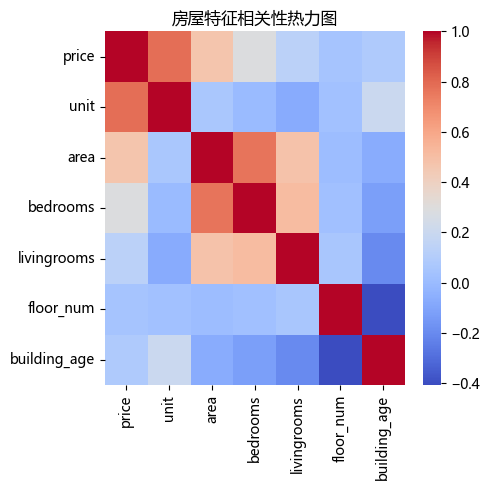

In [3]:
'''
问题编号: A1
问题: 哪些变量最影响房价？面积、楼层、房间数哪个影响更大？
分析主题: 特征相关性
分析目标: 了解房屋各特征对房价的线性影响
分组字段: 无
指标/方法: 皮尔逊相关系数
'''
df = pd.read_csv('data/house_sales_clean.csv')

# 选择数值型特征
correlation = df[['price', 'unit', 'area', 'bedrooms', 'livingrooms', 'floor_num', 'building_age']].corr()#相关系数
# 对房价的影响最大的几个因素的排序
price_corr = correlation['price'].sort_values(ascending=False)[1:]
# 相关性的热力图
plt.figure(figsize = (5, 5))
sns.heatmap(correlation, cmap='coolwarm')
plt.title('房屋特征相关性热力图')
plt.tight_layout()

In [ ]:
'''
问题编号: A2
问题: 全国房价总体分布是怎样的？是否存在极端值？
分析主题: 描述性统计
分析目标: 概览数值型字段的分布特征
分组字段: 无
指标/方法: 平均数/中位数/四分位数/标准差
'''
print(df.describe())
# 房价分布直方图
plt.subplot(211)
plt.hist(df['price'], range=(0, 1000),bins=10)
plt.title('房屋价格分布直方图')
plt.xticks(np.arange(0, 1000, 100))
plt.tight_layout()
plt.show()
plt.subplot(212)
sns.histplot(data=df, x='price', xticks=(0, 1000, 100), bins=10, kde=True)
plt.title('房屋价格分布直方图')
plt.tight_layout()
plt.show()

In [ ]:
'''
问题编号: A3
问题: 哪些城市房价最高？直辖市与非直辖市差异如何？
分析主题: 城市对比
分析目标: 比较不同城市房价水平
分组字段: city
指标/方法: 均价/单价中位数/箱线图
'''
# 按城市统计
city_stats = df.groupby('city').agg({
    'price': ['mean', 'median', 'count'],
    'unit': ['mean', 'median']
})
print("\n各城市房价统计:")
display(city_stats.sort_values(('unit', 'mean'), ascending=False).head(10))

# 可视化前10城市
top_cities = city_stats.sort_values(('unit', 'mean'), ascending=False).head(10).index
df_top = df[df['city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df_top, order=top_cities)
plt.title('TOP10城市房价分布对比', fontsize=14)
plt.xlabel('城市')
plt.ylabel('价格(元)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
'''
问题编号: A4
问题: 高价房在面积、楼层等方面有什么特征？
分析主题: 价格分层
分析目标: 识别不同价位房屋特征差异
分组字段: 价格分段(低中高)
指标/方法: 列联表/卡方检验
'''
"""A4 价格分层特征差异分析"""
print("\n=== A4 价格分层特征差异 ===")

# 按价格分段分析特征
price_group = df.groupby('price_labels').agg({
    'area': ['mean', 'median'],
    'building_age': 'mean',
    'unit': 'median',
    'zxs': 'mean'  # 直辖市占比
})

print("\n各价格层级特征对比:")
display(price_group)

# 可视化
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.barplot(x='price_labels', y='area', data=df, estimator=np.median)
plt.title('不同价格层级面积对比')
plt.ylabel('面积(㎡)')

plt.subplot(132)
sns.boxplot(x='price_labels', y='building_age', data=df)
plt.title('不同价格层级楼龄分布')
plt.ylabel('楼龄(年)')


plt.tight_layout()
plt.show()

In [ ]:
'''
问题编号: A5
问题: 哪种户型最受欢迎？三室比两室贵多少？
分析主题: 户型分析
分析目标: 分析不同户型的市场表现
分组字段: rooms
指标/方法: 占比/平均单价/溢价率
'''
"""A5 户型市场表现分析"""
print("\n=== A5 户型分析 ===")

# 提取房间数（示例："3室2厅" -> 3）
df['room_count'] = df['rooms'].str.extract('(\d+)室').astype(float)

# 按户型统计
room_stats = df.groupby('room_count').agg({
    'price': ['mean', 'median'],
    'unit': 'median',
    'area': 'median',
    'city': 'nunique'
}).sort_values(('price', 'mean'))

print("\n各户型市场表现:")
display(room_stats)

# 可视化
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.boxplot(x='room_count', y='price', data=df)
plt.title('不同户型总价分布')
plt.xlabel('房间数')

plt.subplot(132)
sns.scatterplot(x='area', y='price', hue='room_count', data=df, palette='viridis')
plt.title('面积-价格-户型关系')

plt.subplot(133)
sns.barplot(x='room_count', y='unit', data=df, estimator=np.median)
plt.title('不同户型单价对比')
plt.xlabel('房间数')

plt.tight_layout()
plt.show()

In [ ]:
'''
问题编号: A6
问题: 南北向是否真比单一朝向贵？贵多少？
分析主题: 朝向溢价
分析目标: 评估不同朝向的价格差异
分组字段: toward
指标/方法: 方差分析/多重比较
'''
df['toward'].value_counts()
df.groupby('toward').agg({
    'price':['mean','median'],
    'unit':'median',
    'building_age':'mean',
})
# 数据可视化
plt.figure(figsize=(14, 5))
sns.boxplot(x='toward', y='price', data=df)
plt.tight_layout()